In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Load the dataset
file_path = 'ML Project 1 Dataset.csv'
data = pd.read_csv(file_path)

# Display the column names and first few rows
print(data.columns)

# Display the original column names
print("Original column names:", data.columns.tolist())

# Clean column names by stripping leading/trailing whitespace and replacing spaces with underscores
data.columns = [col.strip().replace(' ', '_') for col in data.columns]

# Display the cleaned column names
print("Cleaned column names:", data.columns.tolist())

# Check for missing values
print("Missing values before filling:\n", data.isnull().sum())

# Separate numeric and categorical columns
numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = data.select_dtypes(include=['object', 'category']).columns

# Fill missing values
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].median())
data[categorical_columns] = data[categorical_columns].fillna(data[categorical_columns].mode().iloc[0])

# Verify missing values are handled
print("Missing values after filling:\n", data.isnull().sum())

# List of categorical columns
categorical_columns = ['NEW_CUST', 'SEX', 'MARITAL', 'P_RESTYPE', 'P_CATEGORY']

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode categorical columns
for column in categorical_columns:
    data[column] = label_encoder.fit_transform(data[column])

# Convert any remaining 'YES'/'NO' values to 1/0
data.replace({'YES': 1, 'NO': 0}, inplace=True)

# Display the first few rows after encoding
print(data.head())



Index(['APP_ID', ' CIBIL_SCORE_VALUE ', 'NEW_CUST', 'CUS_CATGCODE ',
       ' EMPLOYMENT_TYPE ', 'AGE', ' SEX  ', ' NO_OF_DEPENDENTS ', ' MARITAL ',
       ' EDU_QUA', '  P_RESTYPE ', ' P_CATEGORY ', ' EMPLOYEE_TYPE ',
       '  MON_IN_OCC ', ' INCOM_EXP_GMI ', 'LTV', ' TENURE ', 'STATUS'],
      dtype='object')
Original column names: ['APP_ID', ' CIBIL_SCORE_VALUE ', 'NEW_CUST', 'CUS_CATGCODE ', ' EMPLOYMENT_TYPE ', 'AGE', ' SEX  ', ' NO_OF_DEPENDENTS ', ' MARITAL ', ' EDU_QUA', '  P_RESTYPE ', ' P_CATEGORY ', ' EMPLOYEE_TYPE ', '  MON_IN_OCC ', ' INCOM_EXP_GMI ', 'LTV', ' TENURE ', 'STATUS']
Cleaned column names: ['APP_ID', 'CIBIL_SCORE_VALUE', 'NEW_CUST', 'CUS_CATGCODE', 'EMPLOYMENT_TYPE', 'AGE', 'SEX', 'NO_OF_DEPENDENTS', 'MARITAL', 'EDU_QUA', 'P_RESTYPE', 'P_CATEGORY', 'EMPLOYEE_TYPE', 'MON_IN_OCC', 'INCOM_EXP_GMI', 'LTV', 'TENURE', 'STATUS']
Missing values before filling:
 APP_ID               0
CIBIL_SCORE_VALUE    0
NEW_CUST             0
CUS_CATGCODE         0
EMPLOYMENT_TYPE 

In [7]:
# Define features and target variable
X = data.drop('STATUS', axis=1)
y = data['STATUS']

# Check class distribution
print("Class distribution:\n", y.value_counts())

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)
print("Class distribution after SMOTE:\n", y.value_counts())

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


Class distribution:
 STATUS
0    8283
1    5016
Name: count, dtype: int64
Class distribution after SMOTE:
 STATUS
0    8283
1    8283
Name: count, dtype: int64


Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best Hyperparameters: {'bootstrap': True, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Accuracy: 0.7193158953722334
Confusion Matrix:
 [[1973  526]
 [ 869 1602]]
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.79      0.74      2499
           1       0.75      0.65      0.70      2471

    accuracy                           0.72      4970
   macro avg       0.72      0.72      0.72      4970
weighted avg       0.72      0.72      0.72      4970

ROC-AUC Score: 0.7742421128710488


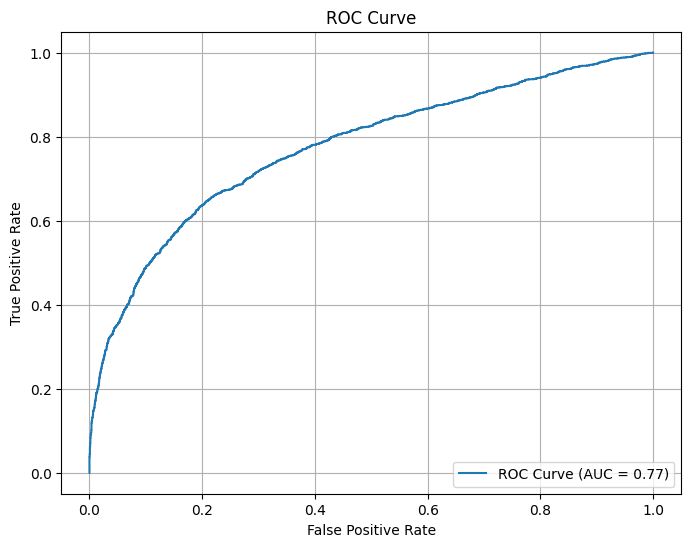

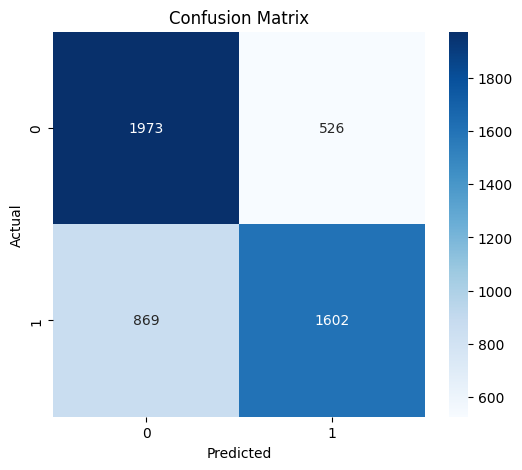

Feature Importances:
                    Importance
APP_ID               0.143867
LTV                  0.139545
CIBIL_SCORE_VALUE    0.133531
AGE                  0.108517
MON_IN_OCC           0.100962
NEW_CUST             0.067942
TENURE               0.062524
NO_OF_DEPENDENTS     0.038438
INCOM_EXP_GMI        0.034679
P_CATEGORY           0.032774
P_RESTYPE            0.026824
EMPLOYEE_TYPE        0.025989
EDU_QUA              0.021922
EMPLOYMENT_TYPE      0.018658
MARITAL              0.017410
SEX                  0.014106
CUS_CATGCODE         0.012312


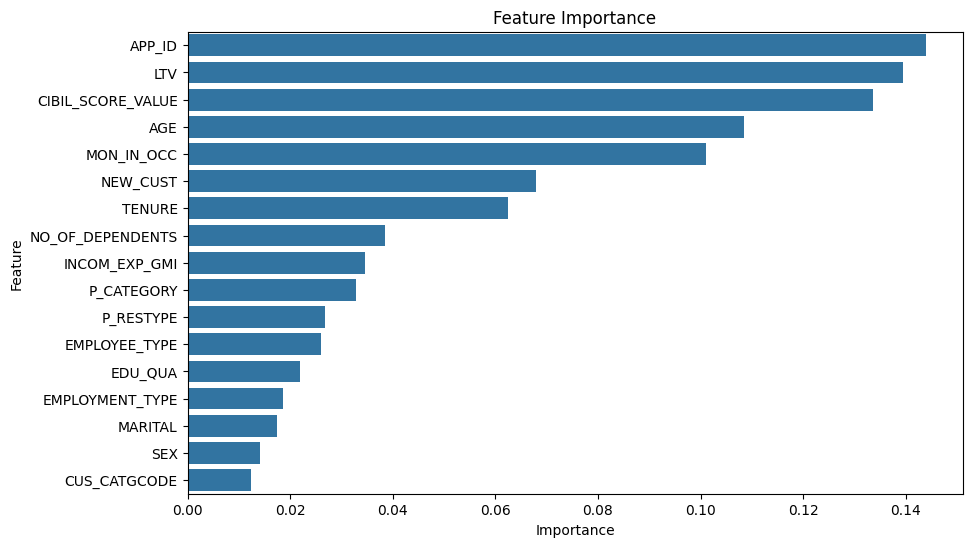

In [8]:

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
}

# Initialize the model with class weights for imbalance
model = RandomForestClassifier(random_state=42, class_weight='balanced')

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Train the model with the best hyperparameters
model = grid_search.best_estimator_
model.fit(X_train, y_train)

# Evaluate the model's performance
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Compute and display ROC-AUC score
roc_auc = roc_auc_score(y_test, y_prob)
print("ROC-AUC Score:", roc_auc)

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Feature Importance
feature_importances = pd.DataFrame(
    model.feature_importances_,
    index=X.columns,
    columns=['Importance']
).sort_values(by='Importance', ascending=False)

print("Feature Importances:\n", feature_importances)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances['Importance'], y=feature_importances.index)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()